In [1]:
def categorical_crossentropy(t,y):
    return np.mean(-t*np.log(y+0.0001))

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [3]:
def softmax(x):
    c = np.max(x,axis=1).reshape(-1,1)
    x = x-c
    return np.exp(x)/np.sum(np.exp(x),axis=1).reshape(-1,1)

In [4]:
import numpy as np
class Relu:
    def __init__(self):
        self.mask = None
    def forward(self,x):
        self.mask = (x <=0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout
        return dx
        
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self,x):
        out = sigmoid(x)
        self.out = out
        return out
    
    def backward(self,dout):
        dx = ((1-self.out)*self.out)*dout
        return dx

class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.x = None
        self.origin_shape = None
        self.dW = None
        self.db = None
    
    def forward(self,x):
        self.origin_shape = x.shape
        self.x = x
        out = np.dot(x,self.W) + self.b
        return out
    
    def backward(self,dout):
        dx = np.dot(dout,self.W.T)
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout,axis=0)
        dx = dx.reshape(self.origin_shape)
        return dx

class Loss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self,t,y):
        self.y = softmax(y)
        self.t = t
        self.loss = categorical_crossentropy(self.t, self.y)
        return self.loss
    
    def backward(self,dout=1):
        dx = (self.y - self.t)*dout
        return dx

In [5]:
class Layers:
    def __init__(self):
        self.layers = {}
        
    def add(self,x1,x2,activation):
        activation_dict = {
            'sigmoid':Sigmoid,
            'relu':Relu,
            'softmax':Loss
        }
        w = np.random.randn(x1,x2)
        b = np.zeros(x2)
        activation_layer = 'activation'+str((int(len(self.layers)/2+1))) 
        Affine_layer = 'Affine'+str((int(len(self.layers)/2+1)))
        self.layers[Affine_layer] = Affine(w,b)
        self.layers[activation_layer] = activation_dict[activation]()
        
    
    def predict(self,x):
        out = x.copy()
        ind = 1 
        layer_len = len(self.layers)
        for key, layer in self.layers.items():
            if ind < layer_len :
                out = layer.forward(out)
            ind += 1
        return out
            
    
    def loss(self,x,t):
        y = self.predict(x)
        out = list(self.layers.values())[-1].forward(t,y)
        return out
    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y,axis=1)
        t = np.argmax(t,axis=1)
        self.acc = np.sum(y==t)/t.size
        return self.acc
    
    def gradient(self,x,t):
        self.loss(x,t)
        lr = 1e-4
        dout = 1
        dout = list(self.layers.values())[-1].backward(dout)
        layers = list(self.layers.values())[::-1][1:]
        self.layers_key = list(self.layers.keys())[::-1][1:]
        for layer in layers:
            dout = layer.backward(dout)
        self.grads = {}
        for layer_key in self.layers_key:
            if 'Affine' in layer_key:
                self.grads[layer_key] = [self.layers[layer_key].dW, self.layers[layer_key].db]
        for layer_key in self.layers_key:
            if 'Affine' in layer_key:
                self.layers[layer_key].W -= lr*self.grads[layer_key][0]
                self.layers[layer_key].b -= lr*self.grads[layer_key][1]
        result = self.loss(x,t)       
        return result
    
    def fit(self,x,t,epochs,lr):
        self.lr = lr
        self.history = {}
        accuracy = []
        loss = []
        for epoch in range(epochs):
            self.gradient(x,t)
            loss.append(self.err)
            accuracy.append(self.accuracy(x,t))
            if epoch % 100 == 0:
                print(f'loss : {self.err} === accuracy : {self.accuracy(x,t)}')
        self.history['accuracy'] = accuracy
        self.history['loss'] = loss
                

In [16]:
# 필요한 모듈 호출
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 텐서플로우 모듈
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from keras.datasets import mnist

In [156]:
# 데이터 수집
(x_train_full, y_train_full),(x_test_full, y_test_full) = mnist.load_data()

In [157]:
# y 데이터 바이너리 범주형 변환
y_train_full[np.isin(y_train_full, (1,7,9))== False] = 0
y_train_full[np.isin(y_train_full, (1,7,9))== True] = 1

In [158]:
y_test_full[np.isin(y_test_full, (1,7,9))== False] = 0
y_test_full[np.isin(y_test_full, (1,7,9))== True] = 1

In [159]:
# 데이터 분배
x_train, x_val, y_train, y_val = \
    train_test_split(x_train_full, y_train_full, test_size= .2, random_state=42)

In [160]:
# 분배 및 차원 확인
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(48000, 28, 28)
(12000, 28, 28)
(48000,)
(12000,)


In [161]:
y_train

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

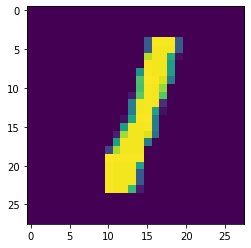

target = 1


In [165]:
# 데이터 타입 확인
plt.imshow(x_train[2])
plt.show()
print('target =', y_train[2])

In [166]:
# x 데이터 reshape
x_train_reshape = x_train.reshape(-1,784)
x_val_reshape = x_val.reshape(-1, 784)
x_test_reshape = x_test.reshape(-1, 784)

In [167]:
# y 데이터 종류
# 연속형
# 바이너리 범주형(둘중하나) -> 0, 1 변경
# 카테고리컬 범주형(2개이상) -> one_hot 변경

# y 데이터 확인 -> 카테고리컬 범주형 -> one_hot
np.unique(y_train)

array([0, 1], dtype=uint8)

In [172]:
# 모델생성
model2 = Sequential()
l1 = Dense(1024, activation ='relu', input_shape=(784,))
batch = keras.layers.BatchNormalization()
l2 = Dense(512, activation ='relu')
out = Dense(1, activation='sigmoid')
model2.add(l1)
model2.add(batch)
model2.add(l2)
model2.add(out)

In [173]:
# 모델설정
optimizer = 'sgd'
loss = 'binary_crossentropy'
metrics = ['accuracy']
model2.compile(
    optimizer= optimizer,
    loss= loss,
    metrics = metrics
)

In [174]:
# 모델 학습
model2.fit(
    x_train_reshape,
    y_train,
    epochs = 10,
    batch_size = 400,
    validation_data =(x_val_reshape, y_val),
    verbose = 1
)

Epoch 1/10
120/120 [==============================] - 3s 18ms/step - loss: 0.2106 - accuracy: 0.9238 - val_loss: 0.1388 - val_accuracy: 0.9528
Epoch 2/10
120/120 [==============================] - 2s 17ms/step - loss: 0.1143 - accuracy: 0.9641 - val_loss: 0.1015 - val_accuracy: 0.9667
Epoch 3/10
120/120 [==============================] - 2s 16ms/step - loss: 0.0943 - accuracy: 0.9693 - val_loss: 0.0887 - val_accuracy: 0.9713
Epoch 4/10
120/120 [==============================] - 2s 17ms/step - loss: 0.0824 - accuracy: 0.9735 - val_loss: 0.0805 - val_accuracy: 0.9741
Epoch 5/10
120/120 [==============================] - 2s 17ms/step - loss: 0.0743 - accuracy: 0.9764 - val_loss: 0.0745 - val_accuracy: 0.9758
Epoch 6/10
120/120 [==============================] - 2s 17ms/step - loss: 0.0686 - accuracy: 0.9776 - val_loss: 0.0699 - val_accuracy: 0.9777
Epoch 7/10
120/120 [==============================] - 2s 17ms/step - loss: 0.0631 - accuracy: 0.9795 - val_loss: 0.0665 - val_accuracy: 0.9782

In [221]:
## 활용
def mnist_test(size):
    index = np.random.choice(np.arange(len(x_test_reshape)),size,replace=False)
    size = size
    score = 0

    for i in index:
        plt.imshow(x_test_reshape[i].reshape(28,28))
        predict = np.where(model2.predict(x_test_reshape[[i]]) > 0.5,1,0)
        real = y_test_full[i]
        if predict == real:
            result = '정답'
            score += 1
        else :
            result = '오답'
        plt.show()
        print('실제값=',real)
        print('예측값=',predict)
        print(result)
    score_per = (score/size)*100
    print('=======================================')
    print('총 정답 갯수=',score)
    print(f'예측률= {score_per}%')
    print('=======================================')

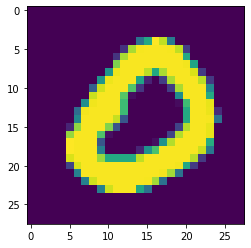

실제값= 0
예측값= [[0]]
정답


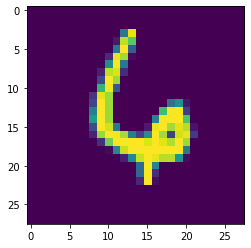

실제값= 0
예측값= [[0]]
정답


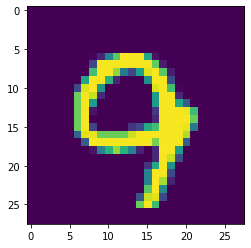

실제값= 1
예측값= [[1]]
정답


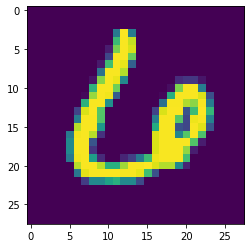

실제값= 0
예측값= [[0]]
정답


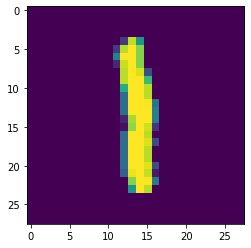

실제값= 1
예측값= [[1]]
정답
총 정답 갯수= 5
예측률= 100.0%


In [222]:
mnist_test(5)

In [ ]:
model2 = Sequential()
model2.compile()

In [ ]:
model1.compile(
    optimizer= optimizer,
    loss= loss,
    metrics = metrics
)